# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [97]:
%matplotlib inline
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
from bring_the_func import *

First we need to read in the photometry data. This notebook assumes that photometry has been performed with [AstroImageJ](https://www.astro.louisville.edu/software/astroimagej/) and a table of measurements has been saved as a .csv file. In this example, I also pull the preliminary planet and star parameters from a table that I created, but you can insert your parameters however you wish.

In [98]:
data_path = '/Users/willwaalkes/Desktop/CU_Boulder/Research/TESS_Followup/'

In [103]:
data = pandas.read_csv(data_path+'TIC_447061717/TIC447061717-01_20200223_LCO-SAAO-1m_ic_measurements.csv')
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']
err_kludge = 1.0

In [104]:
# times_bjd = np.array(data['BJD_MOBS'])
# times_jd = np.array(data['JD_UTC'])
# plt.plot(times_jd-times_bjd)
# plt.ylabel('JD - BJD')
# plt.xlabel('index')

In [107]:
index = int(155)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'LCO 1-m'
print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 259962054
TOI 203.01


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

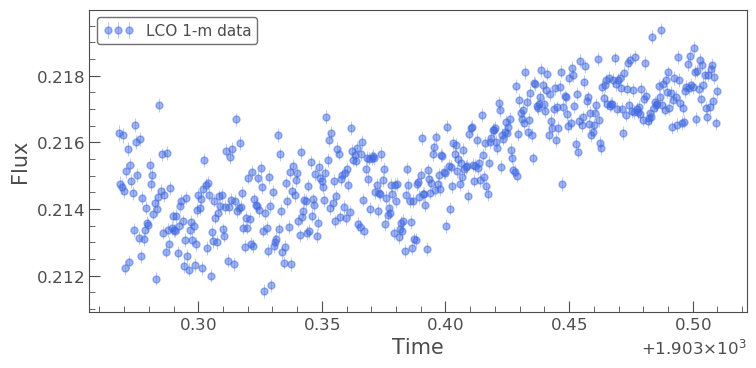

In [84]:
flux = np.array(data['rel_flux_T1'])
error = np.array(data['rel_flux_err_T1'])*err_kludge #inflates the error bars to give a best fit chi2=1
#times = np.array(data['BJD-OBS'])
times = np.array(data['BJD_MOBS'])
#times = np.array(data['BJD_TDB'])
airmass = np.array(data['AIRMASS'])
exptime_s = 100
#exptime_s = np.median(data['EXPTIME'])
exptime_d = exptime_s * (1/60) * (1/60) * (1/24) #converting exposure time to days

offset = 2457000
times = times-offset # This is just a constant offset to make the x-axis more readable

if str(tic_id) == '348538431.0':
    
    mask = np.ones(len(flux), dtype=bool)
    mask[[101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118]] = False

    flux = flux[mask]
    error = error[mask]
    times = times[mask]
    airmass = airmass[mask]

lc = LightCurve(time = times, flux = flux, flux_err = error).remove_outliers(sigma=10)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

Now let's turn this into a **lightkurve** object

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [110]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
C1 = 0.2175#np.median(lc.flux) #C1 and C2 are the airmass correction parameters
C2 = 0.0
depth = C1*(1-ppm_depth/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + Epoch)

#print(ppm_depth)

for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]-1):
        if (mid_transit_times[i] <= lc.time[-1]+1):
            
            expected_t0 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0))
            print("Anticipated depth = {:.4f}".format(depth))

In [142]:
lcf = lk.search_lightcurvefile('TIC {}'.format(int(tic_id))).download_all()

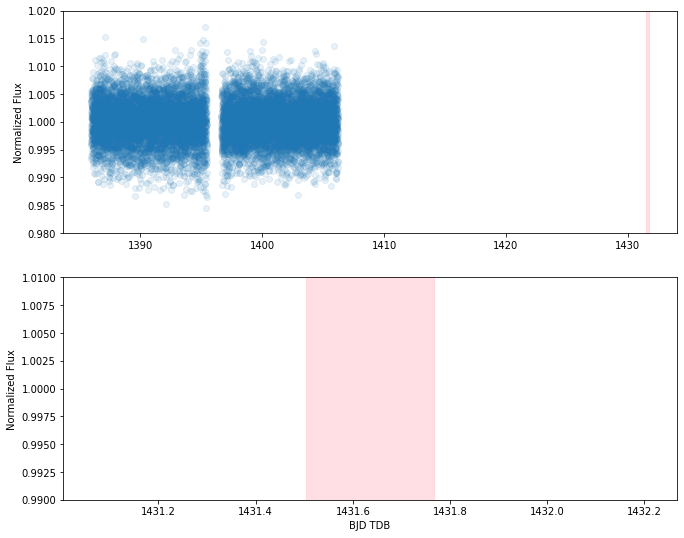

In [214]:
TLC = lcf[2].PDCSAP_FLUX.remove_outliers(sigma=10).normalize()
n = 2

fig, (ax0,ax1) = plt.subplots(2,1,figsize=(11,9))

#init_model = BATMAN(planet_period,planet_radius,t0=Epoch,inc=planet_i,
#                    A=planet_a,LD=[0.31,0.32],t = TLC.time)

ingress = (Epoch+n*planet_period)-(planet_duration/2)/24
egress = (Epoch+n*planet_period)+(planet_duration/2)/24

ax0.scatter(TLC.time, TLC.flux, alpha=0.1,rasterized=True)
ax0.axvspan(ingress, egress, alpha=0.5, color='pink')

ax0.set_ylabel('Normalized Flux')
ax0.set_ylim(0.98,1.02)


ax1.scatter(TLC.bin(binsize=5).time, TLC.bin(binsize=5).flux, alpha=0.2)
ax1.axvspan(ingress, egress, alpha=0.5, color='pink',zorder=-2)
#ax1.plot(TLC.time, init_model, color='k',zorder=-1)

ax1.set_xlim(ingress-0.5, egress+0.5)
ax1.set_ylim(0.99,1.01)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('BJD TDB')

plt.savefig('Figs/TOI_203_Third_sector.pdf')
plt.show()

In [95]:
#print(0.2175-C1)
print(C1)

0.2175


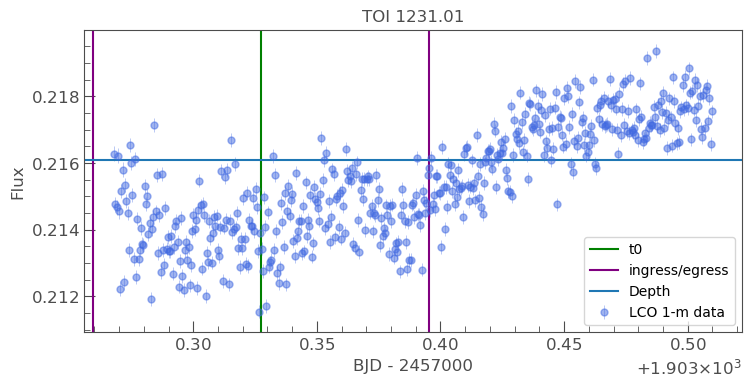

In [96]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title('TOI {}'.format(toi))
plt.xlabel('BJD - {}'.format(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.axhline(depth,label='Depth')
plt.legend()
plt.savefig('Figs/TOI_{}_NoFit.png'.format(toi))
plt.show()

In [75]:
star_met = 0
LD_coeff = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
LD = [LD_coeff[0][0],LD_coeff[0][1]]

#LD = [0.6601,0.31006] #This is for TIC 348538431
#LD = [0.67528,0.25598] #This is for TIC 5868998
#LD = [0.70147,0.022237] #This is for TIC 220479565
#LD = [0.65655,0.32989] #This is for TIC 272086159

TypeError: buffer is too small for requested array

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

4300.702385655014


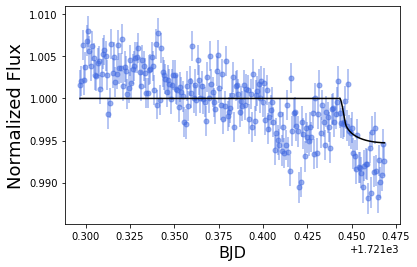

In [12]:
theta = [C1, C2, planet_radius, expected_t0, planet_a, planet_i]
static_params = [planet_radius, planet_period, planet_a, planet_i,
                 expected_t0, LD, offset, observatory, airmass, toi]

a = lnprob(theta, lc, planet_period, LD, airmass, planet_a, expected_t0, plot = True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [13]:
# intialize some walkers
ndim, nwalkers, nsteps = 6, 100, 15000
burnin = int(0.2*nsteps)

# these are initial parameters
C1_init = np.random.uniform(C1-0.0005, C1+0.0005, nwalkers)
C2_init = np.random.uniform(0.0,0.000001, nwalkers)
Rp_init = np.random.uniform(planet_radius-0.001, planet_radius+0.001, nwalkers)
t0_init = np.random.uniform(expected_t0-0.00001,expected_t0+0.00001, nwalkers)
a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

labels = ['C1','C2','Rp/R*','T0','a/R*','i (deg)'] #this is for the corner plot

p0 = np.transpose([C1_init, C2_init, Rp_init, t0_init, a_init, i_init])

In [14]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (lc,planet_period,LD,airmass,planet_a, expected_t0))
result = sampler.run_mcmc(p0, nsteps)

In [15]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
C1_sam, C2_sam, Rp_sam, t0_sam, A_sam, Inc_sam = samples

sig1_C1 = np.percentile(C1_sam, [16., 50., 84.])
sig1_C2 = np.percentile(C2_sam, [16., 50., 84.])
sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_t0 = np.percentile(t0_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

parameters = [sig1_C1[1],sig1_C2[1],sig1_Rp[1],sig1_t0[1],sig1_A[1],sig1_Inc[1]]

best_fit_model = (sig1_C1[1] + sig1_C2[1]*(airmass-1))*BATMAN(P = planet_period,Rp = sig1_Rp[1],
                                                              t0 = sig1_t0[1],
                                                              inc = sig1_Inc[1],
                                                              A = sig1_A[1], LD = LD,
                                                              t = lc.time)
reduced_chisq = np.sum((lc.flux - best_fit_model)**2/(lc.flux_err)**2)/(len(lc.flux)-4)     
err_kludge = np.sqrt(reduced_chisq)
print(err_kludge)

np.savetxt(fname='Data/TESS/TOI_{}_samples.txt'.format(toi),X=samples)

1.4289817912445464


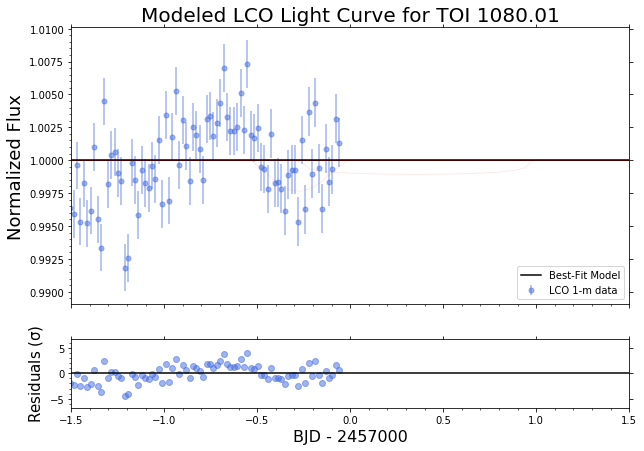

In [16]:
light_curve(lc, parameters, sampler, static_params, nsteps, Epoch, tic_id)

In [17]:
#plot_chain(sampler, static_params, start=burnin, stop=nsteps)

In [18]:
#corner(samples, labels, toi)

In [19]:
for i in range(len(samples)):
    tau_f = emcee.autocorr.integrated_time(samples[i])
    print((nsteps-burnin)/tau_f)

[82.39173864]
[75.33848678]
[74.02113559]
[73.39838516]
[74.03652767]
[110.53213759]


In [20]:
#rms_plot(lc, parameters, static_params)

In [21]:
print('C1 = {:.5f}'.format(sig1_C1[1]),
      '+ {:.5f}'.format(sig1_C1[2]-sig1_C1[1]),
      '- {:.5f}'.format(sig1_C1[1]-sig1_C1[0]))

print('C2 = {:.5f}'.format(sig1_C2[1]),
      '+ {:.5f}'.format(sig1_C2[2]-sig1_C2[1]),
      '- {:.5f}'.format(sig1_C2[1]-sig1_C2[0]))

print('Flux Deficit at Mid-Transit = {:.3f} ppt'.format((
      1-np.amin(best_fit_model/(sig1_C1[1] + sig1_C2[1]*(airmass-1))))*1000))

print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(offset+sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print("Anticipated mid-transit time = {:.6f}".format(offset+expected_t0))

results = Table({'rp':[sig1_Rp[1]],
                 'drp':[sig1_Rp[1]-sig1_Rp[0]],
                 't0':[sig1_t0[1]],
                 'dt0':[sig1_t0[1]-sig1_t0[0]],
                 'a':[sig1_A[1]],
                 'da':[sig1_A[1]-sig1_A[0]],
                 'i':[sig1_Inc[1]],
                 'di':[sig1_Inc[1]-sig1_Inc[0]]},
                names=['rp','drp','t0','dt0','a','da','i','di'])
ascii.write(results,'Data/TESS/TOI_{}_bestfitparams.txt'.format(toi))

C1 = 0.20230 + 0.00005 - 0.00005
C2 = -0.00480 + 0.00017 - 0.00017
Flux Deficit at Mid-Transit = 0.000 ppt
Rp/R* = 0.4956 + 0.3476 - 0.3427
Rp (R_E) = 15.367 + 10.776 - 10.624
a/R* = 24.427 + 3.418 - 3.427
Inclination (Deg) = -1697191478251318776232516658033489218801500160.000 + 1697191478251318776232516658033489218801500160.000 - 17624662780477916002918481553684017621504373523306914338169482641408.000
Impact parameter (b) = -14.583
Mid-Transit Time = 2458721.470961 + 0.010275 - 0.010394
Anticipated mid-transit time = 2458721.470933
